# Cogvis for image classification

In this short tutorial, we implement an application that uses the `cogvis` package for neural network-based image classification. The aim of this application is to classify shrubs (of orchards) into different classes with each class representing a different crop type. More specifically,
* we need to evaluate the effectiveness of `cogvis` in assisting in each stage of an ML pipeline as would be used in an image classification application.
* the stages include data loading, data transforms, model instantiation and training, model prediction and model evaluation.

## The dataset  

The dataset we are working with comprises images of segmented trees or shrubs. We obtain these images by segmenting an aerial image of an orchard using a segmentation mask. The orchard image and segmentation mask are given as GeoTIFF and GeoJSON files respectively. 

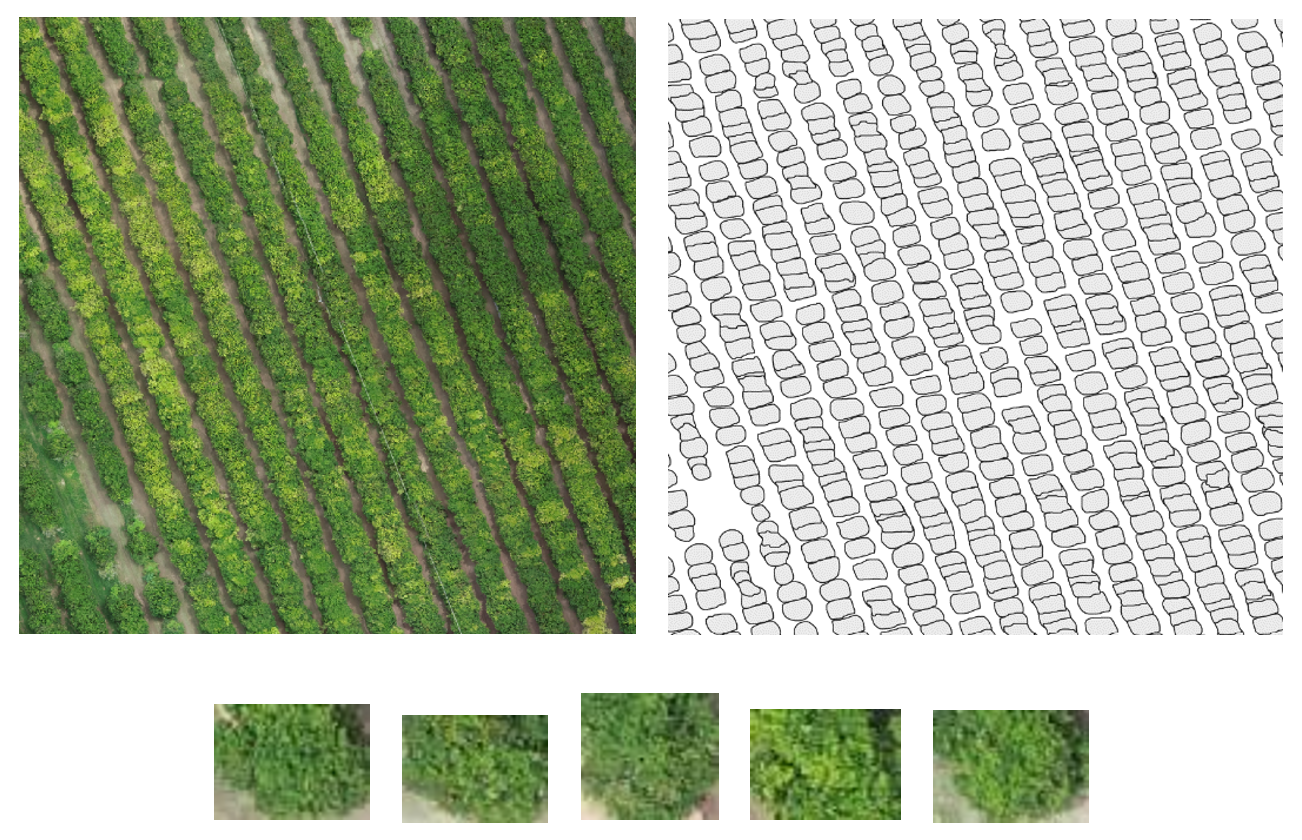

The above picture shows one of the orchard inputs out of five and a few resulting segments. The code used to obtain these segmentations is given below.

In [1]:
def geojson_to_polygon(file_path):
    polygons = []
    with open(file_path) as f:
        geojson_data = geojson.load(f)
        for feature in geojson_data.features:
            polygons.append(feature.geometry.coordinates[0])
    return polygons 


def location_to_coords(x, y, transform):
    x_origin = transform[0]
    y_origin = transform[3]
    pixel_width = transform[1]
    pixel_height = transform[5]
    x_offset = int((x-x_origin)/pixel_width)
    y_offset = int((y-y_origin)/pixel_height)
    return x_offset, y_offset


def segment_polygon(array, polygon):
    x_min = min([coord[0] for coord in polygon]) 
    x_max = max([coord[0] for coord in polygon]) 
    y_min = min([coord[1] for coord in polygon]) 
    y_max = max([coord[1] for coord in polygon]) 
    return array[:, y_min:y_max, x_min:x_max] 


def save_polygon_segments(save_path, polygon_filename, orchard_filename):
    polygons = geojson_to_polygon(polygon_filename)
    image = gdal.Open(orchard_filename)
    T = image.GetGeoTransform()
    array = image.ReadAsArray()[:-1] # discard transparency channel
    for idx, polygon in enumerate(polygons):
        polygon = [location_to_coords(*loc, T) for loc in polygon]
        segment_arr = segment_polygon(array, polygon)
        segment_arr = np.dstack(tuple(ch for ch in segment_arr))
        segment_image = Image.fromarray(segment_arr, 'RGB')
        segment_image.save(f'{save_path}/shrub_{idx}.jpeg')


## Let us get started

Now that we have our images ready, we can use `cogvis` for image classification. Before we get started, you will need to install `cogvis`. You can grab the wheel off our [Github page](https://github.com/TimothySimons/CVS_framework) or build from source.

In [2]:
!pip install /content/cogvis-0.0.1-py3-none-any.whl

Processing ./cogvis-0.0.1-py3-none-any.whl


We need the following imports ...



In [3]:
import random

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
# and most importantly...
from cogvis.classification import nn_classification

and a random seed ...

In [4]:
SEED = 1234

random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

The first ML stage involves a datastore and a data loader. `cogvis` requires that images be stored in one of two ways: the first being as normal images files (.jpg, .png, .tif, etc.) and the other as an HDF5 file. The latter is typically much faster but imposes more constraints on the stored data.

###Images as datastore
`cogvis` requires the directory structure below when loading image files from a directory. Class labels are inferred from the relevant folders. Unlike when using HDF5 as a datastore, `cogvis` does not require any pre-processing.
```
train/
├── class_0/
|   ├── 001.jpg
|   ├── 002.jpg
|   └── 003.jpg
├── class_1/
|   ├── 004.jpg
|   └── 005.jpg
└── etc.
```
### HDF5 as datastore
When using an HDF5 dataset, each class's data needs to be stored separately on the file such that each image can be accessed as follows:
```
data = h5py.File(filename, 'r')
instance = data[class_name][instance_idx]
```
HDF5 files require that images be the same size. Furthermore, only transforms that can be applied to `numpy.ndarray` are allowed by `cogvis` when using HDF5 files as a datastore. See the [PyTorch limitations](https://pytorch.org/docs/stable/torchvision/transforms.html?highlight=torchvision%20transforms%20randomhorizontalflip) on applying transforms to `PIL` and `numpy.ndarray` images.


## Data loading and data transforms
In this application, we are going to use HDF5 files as datastores. We need to pass the relevant transforms as an argument to the data loader. Since our images are fairly uniform (most shrubs look the same), there is no need for complex transforms such as `RandomHorizontalFlip(..)` or `RandomPerspective(...)`.

We are going to use `ToTensor()` to convert `numpy.ndarray` of shape (H x W x C) in the range [0, 255] to a `torch.FloatTensor` of shape (C x H x W) in the range [0.0, 1.0]. We will then `Normalize(...)` the images using the mean and standard deviation of each of channel calculated over 1000 images. We normalise images to bring the entire probability distributions of each channel into alignment. 

In [5]:
train_dir = 'train.hdf5'
val_dir = 'val.hdf5'

train_path = '/content/drive/My Drive/orchard_data_hdf5/train.hdf5'
val_path = '/content/drive/My Drive/orchard_data_hdf5/val.hdf5'


transform = nn_classification.data_transform(ToTensor=())
_, loader = nn_classification.data_loader(train_path, 1000, transform=transform)
data, _ = next(iter(loader))
means = [data[:,c].mean().tolist() for c in range(len(data[0]))] 
stds = [data[:,c].std().tolist() for c in range(len(data[0]))]

batch_size = 32
transform = nn_classification.data_transform(
    ToTensor=(),
    Normalize=(means, stds),
)

train_size, train_loader = nn_classification.data_loader(train_path, batch_size, 
                                                         transform=transform)
val_size, val_loader = nn_classification.data_loader(val_path, batch_size, 
                                                     transform=transform)

## Training
What's great about `cogvis` is that you can train and compare different models with ease. We will try a custom CNN and then we will try one of the supported pre-built models from PyTorch called `squeezenet`.

In [6]:
nn_model = nn_classification.CNN([3, 6, 16], [2704, 120, 84, 5], conv_ks=5, pool_ks=2)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(nn_model.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

nn_model = nn_classification.train(
        nn_model, 
        train_loader, val_loader, 
        train_size, val_size, 
        criterion, 
        optimizer,
        exp_lr_scheduler, 
        num_epochs=10,
        )


Epoch: 0/1
----------
Train Loss: 1.5862 Acc: 0.3581
Val. Loss: 1.5244 Acc: 0.4188

Epoch: 1/1
----------
Train Loss: 1.3847 Acc: 0.5579
Val. Loss: 1.2004 Acc: 0.7475

Best Val. Acc: 0.747500


Let's try a pre-built model. All we need to do is change the model and the parameters being optimized. All other function calls remain the same.

In [9]:
nn_model, params = nn_classification.existing('squeezenet1_1', 5)
optimizer = optim.SGD(params, lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

nn_model = nn_classification.train(
        nn_model, 
        train_loader, val_loader, 
        train_size, val_size, 
        criterion, 
        optimizer,
        exp_lr_scheduler, 
        num_epochs=10,
        )

Epoch: 0/9
----------
Train Loss: 1.1197 Acc: 0.4873
Val. Loss: 0.4795 Acc: 0.8037

Epoch: 1/9
----------
Train Loss: 0.4200 Acc: 0.8447
Val. Loss: 0.2472 Acc: 0.9158

Epoch: 2/9
----------
Train Loss: 0.2588 Acc: 0.9068
Val. Loss: 0.2016 Acc: 0.9317

Epoch: 3/9
----------
Train Loss: 0.2033 Acc: 0.9295
Val. Loss: 0.2405 Acc: 0.9117

Epoch: 4/9
----------
Train Loss: 0.1962 Acc: 0.9361
Val. Loss: 0.1738 Acc: 0.9475

Epoch: 5/9
----------
Train Loss: 0.1574 Acc: 0.9471
Val. Loss: 0.5717 Acc: 0.8108

Epoch: 6/9
----------
Train Loss: 0.1735 Acc: 0.9421
Val. Loss: 0.1544 Acc: 0.9467

Epoch: 7/9
----------
Train Loss: 0.0952 Acc: 0.9684
Val. Loss: 0.1035 Acc: 0.9717

Epoch: 8/9
----------
Train Loss: 0.0861 Acc: 0.9731
Val. Loss: 0.0997 Acc: 0.9721

Epoch: 9/9
----------
Train Loss: 0.0825 Acc: 0.9736
Val. Loss: 0.0982 Acc: 0.9712

Best Val. Acc: 0.972083


## Prediction

In [11]:
test_path = '/content/drive/My Drive/orchard_data_hdf5/test.hdf5'
test_size, test_loader = nn_classification.data_loader(test_path, batch_size, 
                                                     transform=transform)
nn_classification.evaluate(nn_model, test_loader, test_size, criterion)


Loss: 0.0904 Acc: 0.9692
